In [76]:
import sympy as sp
import numpy as np
from sympy import latex
from IPython.display import display, Math
import scipy
import time
import matplotlib.pyplot as plt

### 1、状态空间模型

In [77]:
x1,x2,x3,x4 = sp.symbols('x1 x2 x3 x4')
u, mp, L, mc, g = sp.symbols('u mp L mc g')

# 定义状态空间模型
x1_dot = x3
x2_dot = -x4
x3_dot = (u + mp * sp.sin(x2) * (L * x4**2 - g * sp.cos(x2))) / (mc + mp * sp.sin(x2)**2)
x4_dot = (u * sp.cos(x2) + mp * L * x4**2 * sp.cos(x2) * sp.sin(x2) - (mc + mp) * g * sp.sin(x2)) / (L * mc + L * mp * sp.sin(x2)**2)

'''
print(f'x1_dot: ', x1_dot)
print(f'x2_dot: ', x2_dot)
print(f'x3_dot: ', x3_dot)
print(f'x4_dot: ', x4_dot)
'''

display(Math(r"{\dot{x}_1} =" + latex(x1_dot)))
display(Math(r"{\dot{x}_2} =" + latex(x2_dot)))
display(Math(r"{\dot{x}_3} =" + latex(x3_dot)))
display(Math(r"{\dot{x}_4} =" + latex(x4_dot)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

***
***
### 2、在平衡点处线性化
- 求偏导

In [78]:
X = [x1, x2, x3, x4]
f = [x1_dot, x2_dot, x3_dot, x4_dot]
U = [u]
# 计算雅可比矩阵（偏导数矩阵）
pfx = sp.Matrix(len(f), len(X), lambda i, j: sp.diff(f[i], X[j]))
pfu = sp.Matrix(len(f), len(U), lambda i, j: sp.diff(f[i], U[j]))
'''
for i in range(len(f)):
    for j in range(len(X)):
        print(f'pf{i+1}x{j+1}:', pfx[i, j])
    print()

for i in range(len(f)):
    for j in range(len(U)):
        print(f'pf{i+1}u{j+1}:', pfu[i, j])
    print()
'''
# 输出雅可比矩阵 ∂f/∂x
display(Math(r"\frac{\partial f}{\partial x} = " + latex(pfx)))

# 输出雅可比矩阵 ∂f/∂u
display(Math(r"\frac{\partial f}{\partial u} = " + latex(pfu)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

- 在x = 0，u = 0处线性化

In [79]:
x1_hat,x2_hat,x3_hat,x4_hat = 0,0,0,0
u_hat = 0
mp_value = 1
mc_value = 10
g_value = 9.81
L_value = 0.5
subs_list = [
    (x1, x1_hat), (x2, x2_hat), (x3, x3_hat), (x4, x4_hat),
    (u, u_hat), (mp, mp_value), (mc, mc_value), (g, g_value), (L, L_value)
]
A_hat = pfx.subs(subs_list).evalf()
B_hat = pfu.subs(subs_list).evalf()

#转化为numpy矩阵
#A_hat = np.array(A_hat.tolist()).astype(np.float64)
#B_hat = np.array(B_hat.tolist()).astype(np.float64)

display(Math(r"{\hat{A}} = " + latex(A_hat)))
display(Math(r"{\hat{B}} = " + latex(B_hat)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

***
***
### 3、离散时间动力学模型

In [80]:
det_T = 0.002  # 设置步长

# 离散化
A_discrete = np.eye(4) + det_T * A_hat
B_discrete = det_T * B_hat

display(Math(r"A_d = " + latex(A_discrete)))
display(Math(r"B_d = " + latex(B_discrete)))

#转化为numpy矩阵，便于后续计算
A_discrete = np.array(A_discrete.tolist()).astype(np.float64)
B_discrete = np.array(B_discrete.tolist()).astype(np.float64)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

***
***
### 4、使用Mujoco进行至少两组不同初始条件的无控制仿真

In [81]:
import mujoco
import mediapy as media
import numpy as np

import mujoco.viewer as viewer

定义模型，其中小车的质量是10，连杆的质心位于距离小车质心的L处，可视为图中小球的质量

In [82]:
def init_model(qpos = "0 0",qvel = "0 0", det_T = "0.002"):
  #定义模型
  modelxml = f"""
  <mujoco model="CartPole">
    <compiler eulerseq="XYZ"/>
    <default>
      <default class="unused"/>
    </default>
    <asset>
      <texture name="grid" type="2d" builtin="checker" rgb1="0.1 0.2 0.3" rgb2="0.2 0.3 0.4" width="512" height="512"/>
      <material name="grid" class="unused" texture="grid" texrepeat="1 1" texuniform="true" reflectance="0.2"/>
    </asset>
    <option timestep={det_T}/>  <!-- 设置仿真时间步长 -->
    <worldbody>
      <geom name="floor" class="unused" type="plane" condim="3" size="0 0 0.05" material="grid" pos="0 0 -1"/>
      <body name="Cart" pos="0 0 0" euler="0 -0 0">
      <!-- change inertia, different from sdf -->
      <!-- For this model case, with the cart not having any rotational
              degrees of freedom, the values of the inertia matrix do not
              participate in the model. Therefore we just set them to zero
              (or near to zero since sdformat does not allow exact zeroes
              for inertia values). -->
        <inertial pos="0 0 0" mass="10" diaginertia="0.00000000001 0.00000000001 0.00000000001"/>
        <geom name="cart_visual" class="unused" type="box" contype="0" conaffinity="0" group="0" size="0.12 0.06 0.06" pos="0 0 0" euler="0 -0 0"/>
        <joint name="CartSlider" class="unused" type="slide" pos="0 0 0" axis="1 0 0"/>
        <body name="Pole" pos="0 0 0" euler="0 -0 0">
          <inertial pos="0 0 0.5" mass="1" diaginertia="0.00000000001 0.00000000001 0.00000000001"/>
          <geom name="pole_point_mass" class="unused" type="sphere" contype="0" conaffinity="0" group="0" size="0.05" pos="0 0 0.5" euler="0 -0 0"/>
          <geom name="pole_rod" class="unused" type="cylinder" contype="0" conaffinity="0" group="0" size="0.025 0.25" pos="0 0 0.25" euler="0 -0 0"/>
          <joint name="PolePin" class="unused" type="hinge" pos="0 0 0" axis="0 -1 0"/>
        </body>
      </body>
    </worldbody>
    <sensor>
          <!-- joint position sensing -->
          
          <jointpos joint="CartSlider" name="cart_p"/>
          <jointpos joint="PolePin" name="pole_theta"/>
          <!-- joint velocity sensing -->
          <jointvel joint="CartSlider" name="cart_v"/>
          <jointvel joint="PolePin" name="pole_w"/>
          
    </sensor>
    <actuator>
      <motor joint="CartSlider"/>
    </actuator>
    <keyframe>
      <!--set initial states here-->
      <key name="off1" qpos = {qpos} qvel = {qvel} />
    </keyframe>
  </mujoco>     
  """
  return modelxml


#### 初始条件1 的可视化仿真

In [83]:
qpos_1 = '"0 0"'  #设置初始位置
qvel_1 = '"0 0"'  #设置初速度
det_T = '"0.002"'
modelxml_1 = init_model(qpos_1,qvel_1,det_T)
model_1 = mujoco.MjModel.from_xml_string(modelxml_1)
data_1 = mujoco.MjData(model_1)
mujoco.mj_resetDataKeyframe(model_1, data_1,0)
viewer.launch(model_1,data_1)

以GIF的形式输出结果

In [84]:
def show_gif(model,data,duration = 3,framerate = 30):
  #duration = 3    # (seconds)
  #framerate = 30  # (Hz)

  # Simulate and display video.
  frames = []
  mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
  with mujoco.Renderer(model) as renderer:
    while data.time < duration:
      mujoco.mj_step(model, data)
      if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
  media.show_video(frames, fps=framerate, codec='gif')

""

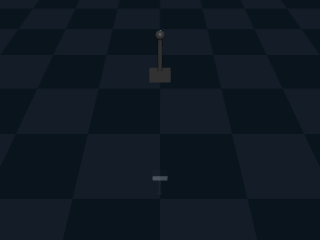

In [85]:
show_gif(model_1,data_1)

由于初始时刻轻杆处于竖直位置，因此在理想条件下将保持竖直状态。

#### 初始条件2 的可视化仿真

In [86]:
qpos_2 = '"0 -0.78"'  #设置初始位置
qvel_2 = '"0 0"'  #设置初速度
det_T = '"0.002"' #设置步长

modelxml_2 = init_model(qpos_2,qvel_2,det_T)
model_2 = mujoco.MjModel.from_xml_string(modelxml_2)
data_2 = mujoco.MjData(model_2)
mujoco.mj_resetDataKeyframe(model_2, data_2,0)
viewer.launch(model_2,data_2)

以GIF形式输出结果

""

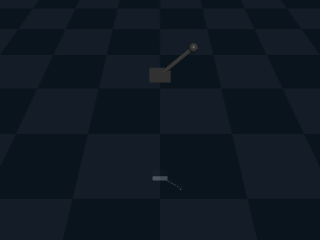

In [87]:
show_gif(model_2,data_1)

该初始条件下，轻杆有一个顺时针与竖直方向成约45°的偏移角，因此在没有外力输入的情况下，形成单摆。
***
***

### 5、仿真
#### （a）选择恰当的Q,R矩阵，计算K矩阵

In [88]:
def setup_lqr_k(A_discrete = A_discrete, B_discrete = B_discrete, 
                Q = np.diag([100000, 0.1, 10, 10],) , R = np.array([[100]])):
 
    A = A_discrete
    B = B_discrete
    
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)
    K = np.linalg.solve(R + B.T @ P @ B, B.T @ P @ A)

    return K

def lqr_controller_with_restrict(model, data, K):
    # 获取当前状态
    x = np.array([
        data.qpos[0],        # 小车位置x1
        -data.qpos[1],       # 杆角度x2（相对于竖直向上位置）
        data.qvel[0],        # 小车速度x3
        data.qvel[1]         # 杆角速度x4
    ])
    u = - K @ x

    # 将控制输入限制在合理范围内
    u = np.clip(u, -50, 50)
    return u,x # 返回标量控制输入和当前状态

def lqr_controller_without_restrict(model, data, K):
    # 获取当前状态
    x = np.array([
        data.qpos[0],        # 小车位置x1
        -data.qpos[1],       # 杆角度x2（相对于竖直向上位置）
        data.qvel[0],        # 小车速度x3
        data.qvel[1]         # 杆角速度x4
    ])
    u = - K @ x
    
    return u,x # 返回标量控制输入和当前状态

In [89]:
def simulate(model,data,K,restrict = True):
    # 数据记录：小车位置、杆角度、时间
    cart_position_data = []
    pole_angle_data = []
    time_data = []

    start_time = time.time()

    with viewer.launch_passive(model, data) as v:  
    # launch_passive means all the simulation should be done by the user 
    
        start = time.time()
        i = 0
        while v.is_running() and time.time() - start < 20:
            step_start = time.time()
            # data.ctrl = 0.2*myControl(model,data)
            if restrict:
                data.ctrl,x = lqr_controller_with_restrict(model, data, K)
            else:
                data.ctrl,x = lqr_controller_without_restrict(model, data, K)
            mujoco.mj_step(model, data)

            # 记录数据
            if i % 10 == 0:
                cart_position_data.append(x[0])
                pole_angle_data.append(x[1])
                time_data.append(T * 10 * i)
            i += 1
            # let viewer show updated info
            v.sync()

            # #  make sure the while loop is called every sampling period 
            # computation inside the loop may take some nontrivial time. 
            time_until_next_step = model.opt.timestep - (time.time() - step_start)
            if time_until_next_step > 0:
                time.sleep(time_until_next_step)

    return cart_position_data, pole_angle_data, time_data

K矩阵将在下一节打印
#### (b) 在不同初始条件下的仿真
##### 初始条件1

In [90]:
qpos_3 = '"-0.1 0.1"'  #设置初始位置
qvel_3 = '"0.1 0.1"'  #设置初速度
det_T = '"0.002"'  #设置步长

Q = np.diag([100000, 0.1, 10, 10])
R = np.array([[100]])
T = 0.002

K = setup_lqr_k(A_discrete,B_discrete,Q,R)
print(f"K = {K}")

modelxml_3 = init_model(qpos_3,qvel_3,det_T)  #初始化模型
model_3 = mujoco.MjModel.from_xml_string(modelxml_3)
data_3 = mujoco.MjData(model_3)
mujoco.mj_resetDataKeyframe(model_3, data_3,0)

cart_position_data,pole_angle_data,time_data = simulate(model_3,data_3,K)

K = [[ -31.2563096  -356.25310923  -39.81346948   78.18922587]]


In [91]:
def plot(time_data,cart_position_data,pole_angle_data,title):    
    plt.figure(figsize=(10, 6))
    plt.suptitle(title, fontsize=15, y=1.0)
    
    # 子图1：小车位置
    plt.subplot(2, 1, 1)
    plt.plot(time_data, cart_position_data, label='Cart Position (m)', color='b')
    plt.title('Cart Position vs Step')
    plt.xlabel('Step')
    plt.ylabel('Position (m)')
    plt.grid()

    # 子图2：杆角度
    plt.subplot(2, 1, 2)
    plt.plot(time_data, pole_angle_data, label='Pole Angle (rad)', color='r')
    plt.title('Pole Angle vs Step')
    plt.xlabel('Step')
    plt.ylabel('Angle (radians)')
    plt.grid()

    plt.tight_layout()
    plt.show()

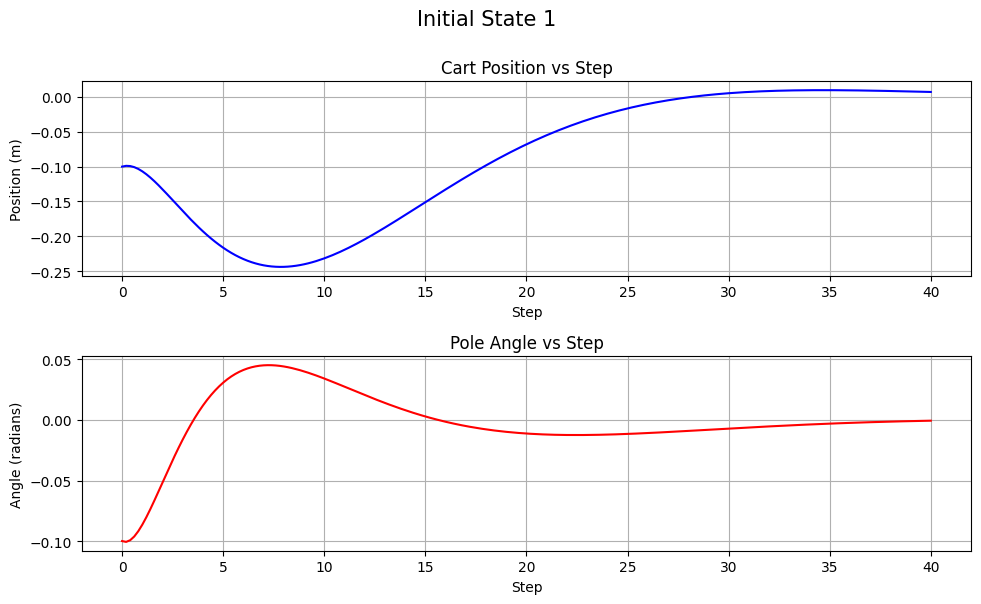

In [92]:
plot(time_data,cart_position_data,pole_angle_data,"Initial State 1")

##### 初始条件2

In [93]:
qpos_4 = '"0 -0.3"'  #设置初始位置
qvel_4 = '"-0.4 0.1"'  #设置初速度
det_T = '"0.002"'  #设置步长
T = 0.002

Q = np.diag([100000, 0.1, 10, 10])
R = np.array([[100]])
T = 0.002

#计算K
K = setup_lqr_k(A_discrete,B_discrete,Q,R)
print(f"K = {K}")

modelxml_4 = init_model(qpos_4,qvel_4,det_T)  #初始化模型
model_4 = mujoco.MjModel.from_xml_string(modelxml_4)
data_4 = mujoco.MjData(model_4)
mujoco.mj_resetDataKeyframe(model_4, data_4,0)

cart_position_data,pole_angle_data,time_data = simulate(model_4,data_4,K)

K = [[ -31.2563096  -356.25310923  -39.81346948   78.18922587]]


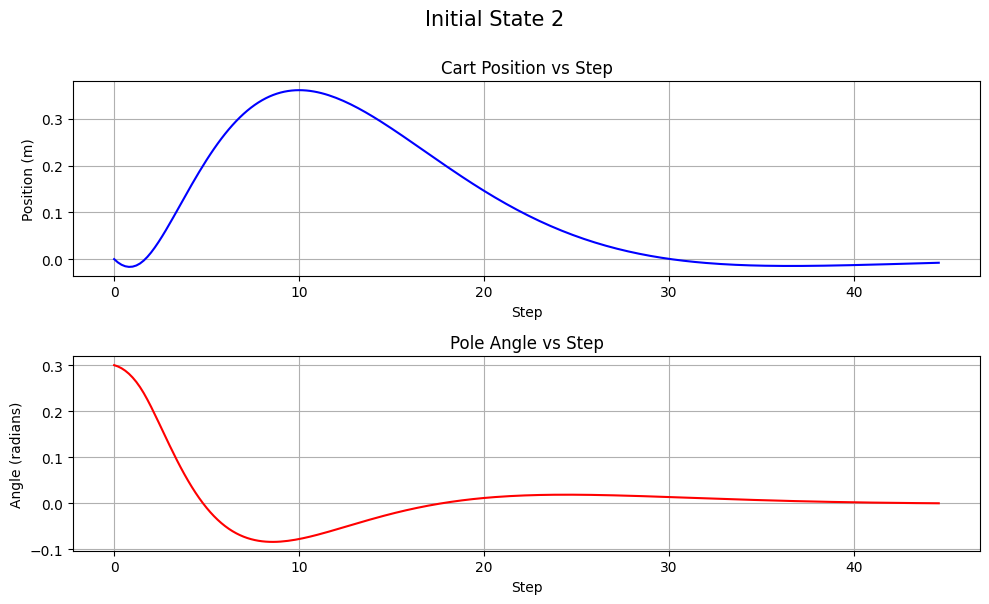

In [94]:
plot(time_data,cart_position_data,pole_angle_data,"Initial State 2")

从两次仿真结果可知，在该QR下，系统收敛速度较快，且响应较为温和。
***
***

### 6、更改Q, R矩阵，再次进行仿真，并与之前的结果进行对比。
此处初始条件设置为```qpos = 0 -0.3``` ,  ```qvel = -0.4 0.1```，与第（5）题中的第二个初始条件相同。

分别设置不同的Q、R

In [95]:
Q_1 = np.diag([0.01, 0.1, 10, 10])
R_1 = np.array([[100]])

Q_2 = np.diag([100000, 1e8, 10, 10])
R_2 = np.array([[100]])

Q_3 = np.diag([100000, 0.1, 1e-6, 10])
R_3 = np.array([[100]])

Q_4 = np.diag([100000, 0.1, 10, 1e-6])
R_4 = np.array([[100]])

Q_5 = np.diag([100000, 0.1, 10, 10])
R_5 = np.array([[1e-8]])

Q_6 = np.diag([100000, 0.1, 10, 10])
R_6 = np.array([[1e4]])


#计算K
K_1 = setup_lqr_k(A_discrete,B_discrete,Q_1,R_1)
print(f"K1 = {K_1}")
K_2 = setup_lqr_k(A_discrete,B_discrete,Q_2,R_2)
print(f"K2 = {K_2}")
K_3 = setup_lqr_k(A_discrete,B_discrete,Q_3,R_3)
print(f"K3 = {K_3}")
K_4 = setup_lqr_k(A_discrete,B_discrete,Q_4,R_4)
print(f"K4 = {K_4}")
K_5 = setup_lqr_k(A_discrete,B_discrete,Q_5,R_5)
print(f"K5 = {K_5}")
K_6 = setup_lqr_k(A_discrete,B_discrete,Q_6,R_6)
print(f"K6 = {K_6}")

K1 = [[-9.90743065e-03 -2.17214582e+02 -5.64755445e-01  4.67832482e+01]]
K2 = [[  -30.93909971 -1193.2266263    -82.77095974   150.65879152]]
K3 = [[ -31.25631541 -356.24485255  -39.81158398   78.18736124]]
K4 = [[ -31.25631612 -356.25100208  -39.81330487   78.18812239]]
K5 = [[-210966.96361441 -235192.4152362  -100787.40269401   53137.83924849]]
K6 = [[  -3.13079027 -252.91405357   -9.62368024   54.84793459]]


对几种情况分别仿真

In [96]:
mujoco.mj_resetDataKeyframe(model_4, data_4,0)
cart_position_data_1,pole_angle_data_1,time_data_1 = simulate(model_4,data_4,K_1,True)

In [97]:
mujoco.mj_resetDataKeyframe(model_4, data_4,0)
cart_position_data_2,pole_angle_data_2,time_data_2 = simulate(model_4,data_4,K_2,True)

In [98]:
mujoco.mj_resetDataKeyframe(model_4, data_4,0)
cart_position_data_3,pole_angle_data_3,time_data_3 = simulate(model_4,data_4,K_3,True)

In [99]:
mujoco.mj_resetDataKeyframe(model_4, data_4,0)
cart_position_data_4,pole_angle_data_4,time_data_4 = simulate(model_4,data_4,K_4,True)

In [100]:
mujoco.mj_resetDataKeyframe(model_4, data_4,0)
cart_position_data_5,pole_angle_data_5,time_data_5 = simulate(model_4,data_4,K_5,True)

mujoco.mj_resetDataKeyframe(model_4, data_4,0)
cart_position_data_51,pole_angle_data_51,time_data_51 = simulate(model_4,data_4,K_5,False)

In [101]:
mujoco.mj_resetDataKeyframe(model_4, data_4,0)
cart_position_data_6,pole_angle_data_6,time_data_6 = simulate(model_4,data_4,K_6,True)

绘制图片,分析结果

Q 是实对称矩阵，其对角线元素$q_{ii}$表示对第$i$个状态变量$x_i$的惩罚；非对角元素$q_{ij}\ (i\ne j)$表示$x_i$和$x_j$之间的耦合惩罚，但通常可以设为0以简化。
R 用于定义输入权重，决定了控制器对控制量的惩罚程度。

decrese q11


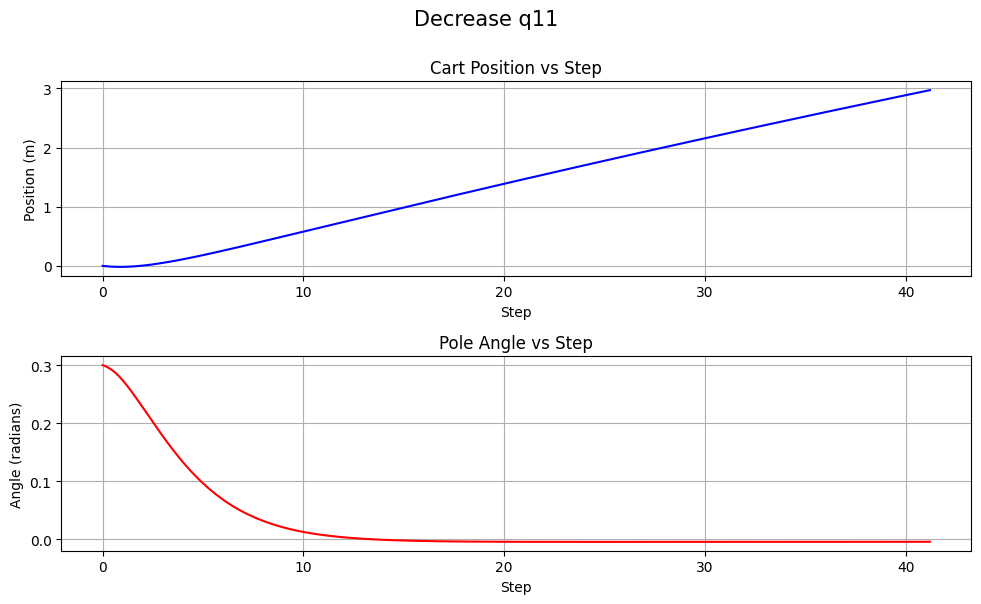

In [102]:
print('decrese q11')
plot(time_data_1,cart_position_data_1,pole_angle_data_1,"Decrease q11")

在本次仿真中，大大降低了$q_{11}$的值，即对$x_1$状态（小车的位置）的惩罚项，导致控制器不再倾向于限制小车的位置。从结果可以看出，小车的位置发散。
***

increase q22


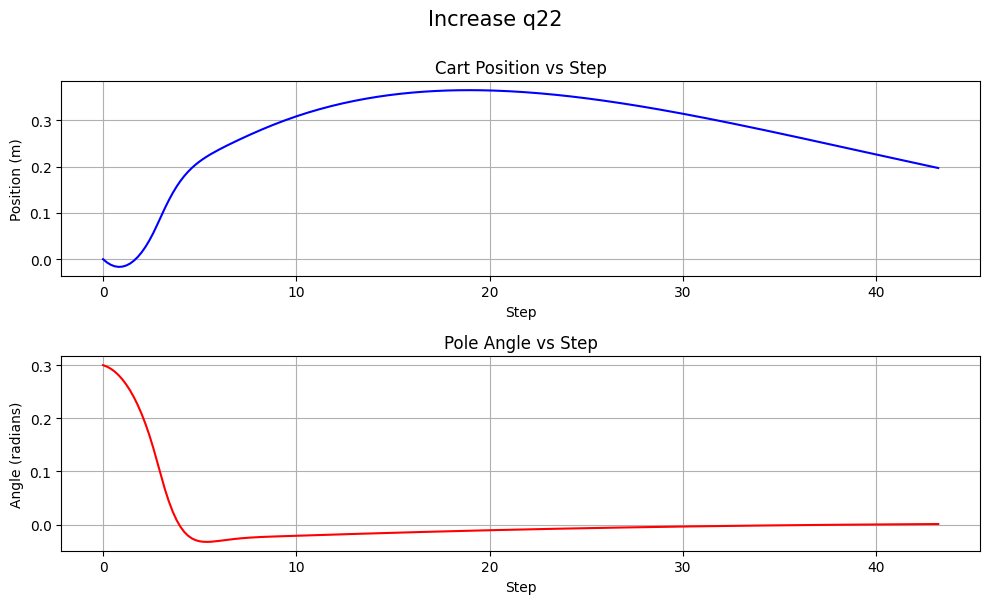

In [103]:
print('increase q22')
plot(time_data_2,cart_position_data_2,pole_angle_data_2,"Increase q22")

在本次仿真中，大大增加了$q_{22}$的值，即对$x_2$状态（杆与竖直的角度）的惩罚项，导致控制器对修正杆角度的力度加大。从结果可以看出，杆与竖直的角度迅速收敛到0，即竖直状态，但同时也导致了$x_1$的收敛速度变慢。
***

decrese q33


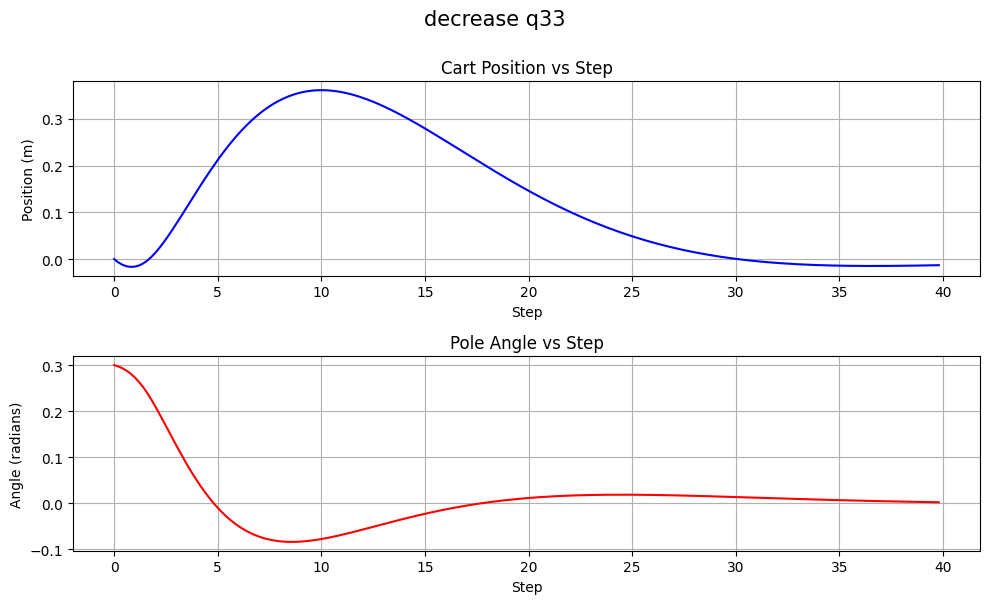

decrese q44


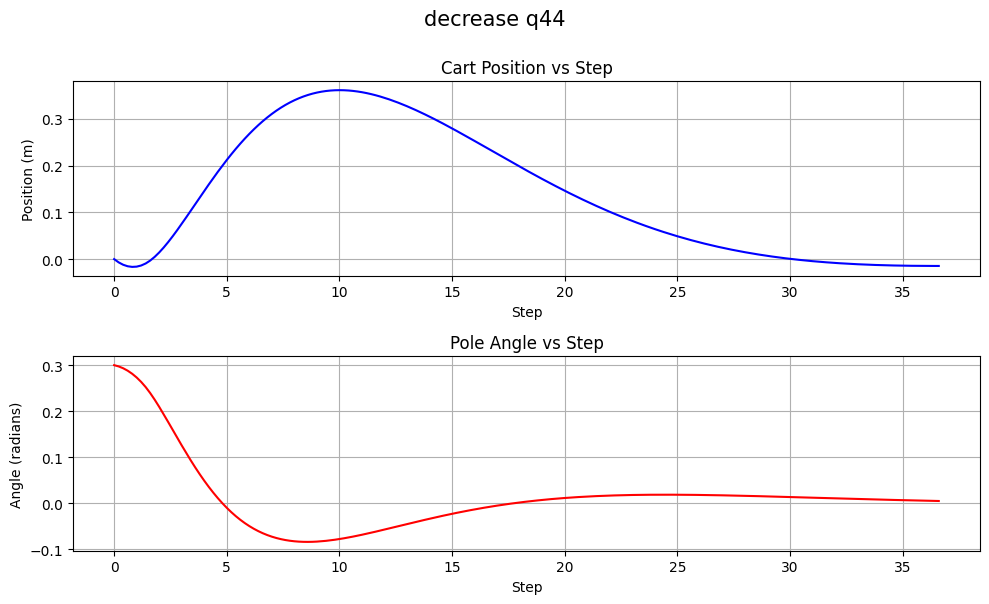

In [104]:
print('decrese q33')
plot(time_data_3,cart_position_data_3,pole_angle_data_3,"decrease q33")

print('decrese q44')
plot(time_data_4,cart_position_data_4,pole_angle_data_4,"decrease q44")

在这两次仿真中，分别大大减小了$q_{33}$和$q_{44}$的值，即对$x_3$、$x_4$状态（小车的速度和杆的角速度）的惩罚项，理论上会导致系统的响应不再温和，但效果并不明显。
***

decrese r


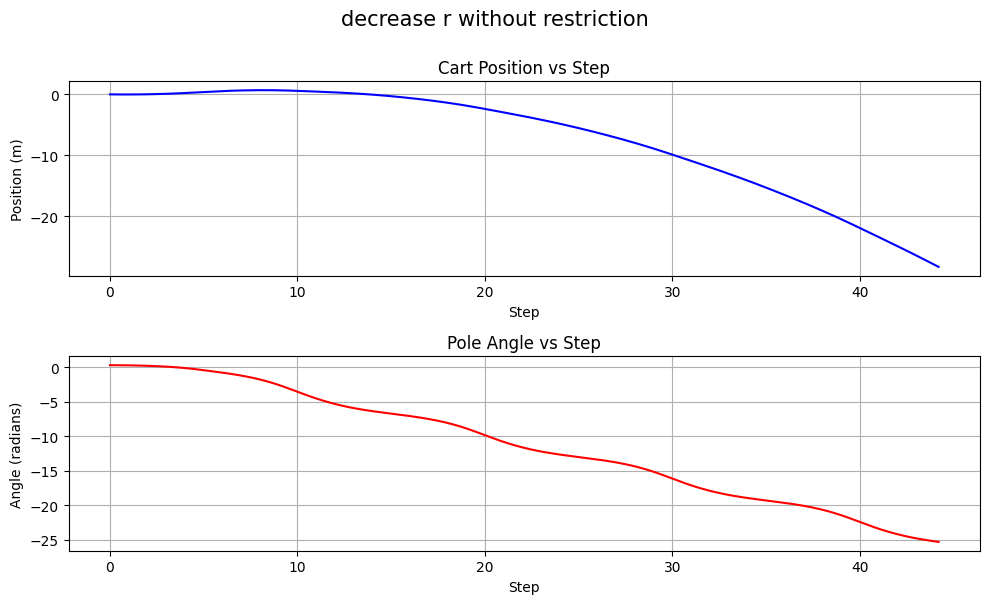

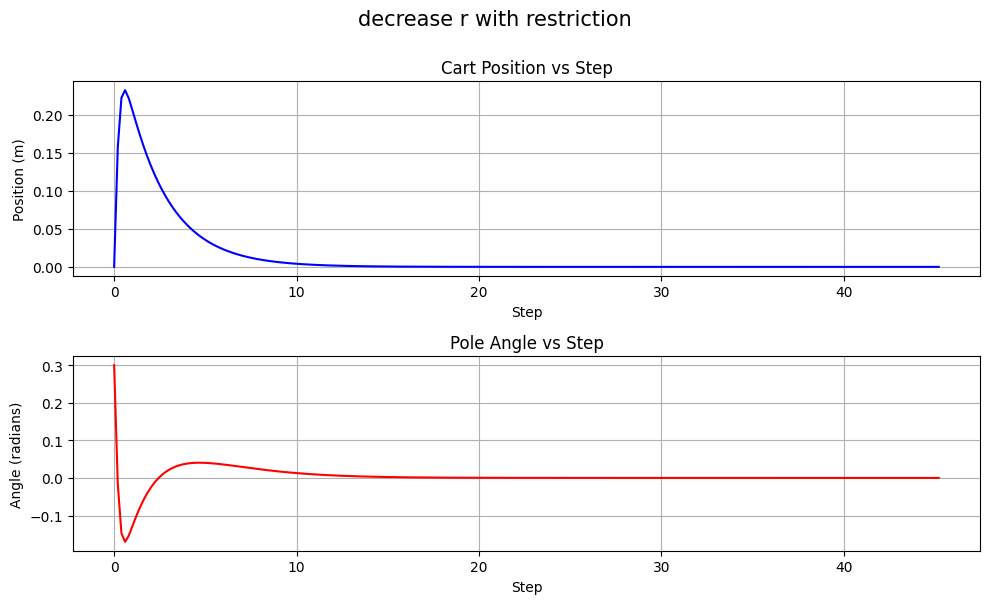

In [105]:
print('decrese r')
plot(time_data_5,cart_position_data_5,pole_angle_data_5,"decrease r without restriction")
plot(time_data_51,cart_position_data_51,pole_angle_data_51,"decrease r with restriction")

由于减小了$r$的值，即减小对控制器的控制量（即施加在小车上的拉力）的惩罚项，这会导致控制力度加大。由于在仿真中对控制器的力度有限制，因此导致实际无法实现通过$u=-Kx$得到的输入，导致系统无法收敛；若解除限制，则可以看出系统的小车的位置和杆与竖直的角度的收敛速度大大加快，系统响应变快。
***

increase r


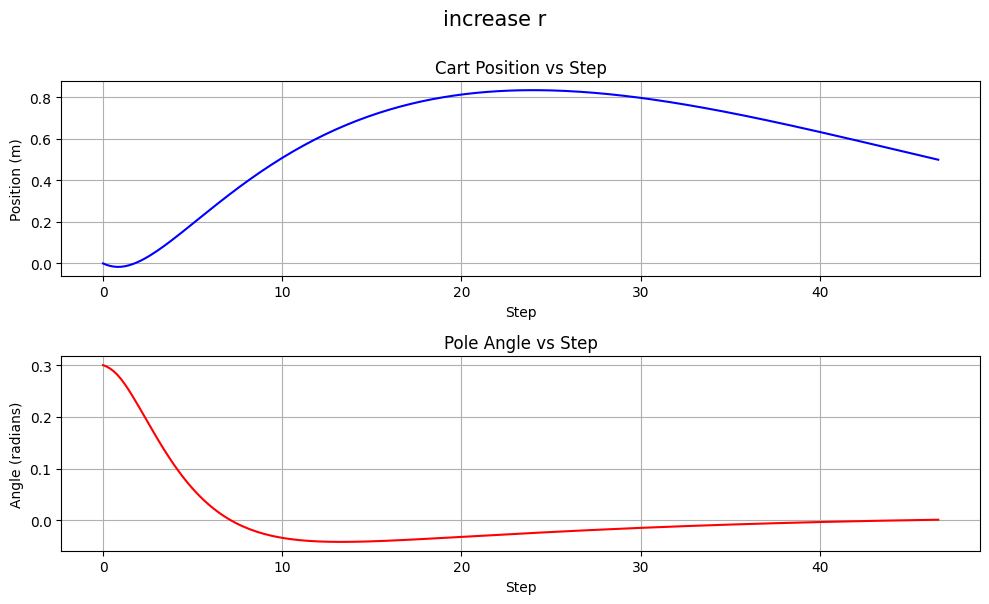

In [106]:
print('increase r')
plot(time_data_6,cart_position_data_6,pole_angle_data_6,"increase r")

在本次仿真中，大大增加了$r$的值，即对控制器的控制量（即施加在小车上的拉力）的惩罚项，这会导致控制力度减小，由结果图可知，系统的响应明显变温和，但收敛速度变慢。
***
- 增加角度$q_{22}$的权重会使控制器更积极地校正杆的角度
- 增加位置$q_{11}$的权重会限制小车的移动范围
- 增加速度项$(q_{33},q_{44})$的权重会使系统响应更平滑
- 减小R值会使控制器使用更大的控制力，响应更快但可能不稳定
- 增大R值会使控制更温和，但可能无法有效稳定系统